In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from param_config import *
from unet_keras import *


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Using TensorFlow backend.


In [2]:
TEST2_PATH = '/work/05268/junma7/data-science-bowl-2018/input/stage2_test/'
test2_ids=next(os.walk(TEST2_PATH))[1]
test2_ids=test2_ids[:100]
X2_test = np.zeros((len(test2_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test2 = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test2_ids), total=len(test2_ids)):
    path = TEST2_PATH + id_
    try:
        img = imread(path  + '/images/'+ id_ + '.png')[:,:,:IMG_CHANNELS]
    except Exception as e:
        print("here")
        pass
    sizes_test2.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X2_test[n] = img

Getting and resizing test images ... 


100%|██████████| 100/100 [00:01<00:00, 52.37it/s]


In [3]:
model = load_model('model-dsbowl2018-augm.h5', custom_objects={'mean_iou': mean_iou})
preds2_test2 = model.predict(X2_test, verbose=1)
# Threshold predictions
preds2_test_t= (preds2_test2 > 0.5).astype(np.uint8)
preds2_test_upsampled = []
for i in range(len(preds2_test2)):
    preds2_test_upsampled.append(resize(np.squeeze(preds2_test2[i]), 
                                       (sizes_test2[i][0], sizes_test2[i][1]), 
                                       mode='constant', preserve_range=True))


100/100 [==============================] - 3s     


In [7]:
model2=load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds3_test2 = model2.predict(X2_test, verbose=1)
preds3_test_t= (preds3_test2 > 0.5).astype(np.uint8)
preds3_test_upsampled = []
for i in range(len(preds3_test2)):
    preds3_test_upsampled.append(resize(np.squeeze(preds3_test2[i]), 
                                       (sizes_test2[i][0], sizes_test2[i][1]), 
                                       mode='constant', preserve_range=True))

ValueError: bad marshal data (unknown type code)

64


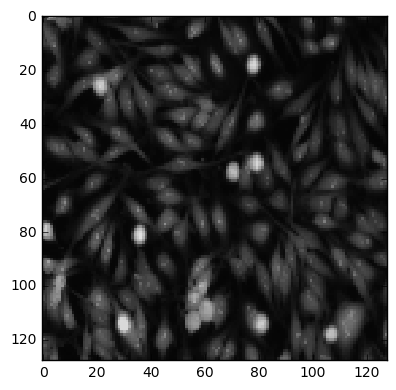

/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


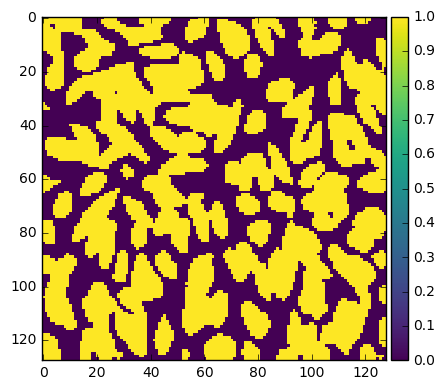

In [14]:
ix = random.randint(0, len(preds2_test_t))
print(ix)
imshow(X2_test[ix])
plt.show()
imshow(np.squeeze(preds2_test_t[ix]))
plt.show()